## Web Scraper
We are scrapping links from direct atheletics (https://www.directathletics.com/rankings.html) to scrap data from the main athletic database (https://www.tfrrs.org/) 

In [52]:
# Download all necessary libraries
%pip install requests beautifulsoup4 pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'd:\Python\python.exe -m pip install --upgrade pip' command.


## Scrapping Team Links 

In [53]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd 
import random
from random import randint
from time import sleep

# URL Link for NCCA Teams
ncaa_url = 'https://www.directathletics.com/leagues/track/48.html'
naia_url = 'https://www.directathletics.com/leagues/track/53.html'
tfrrs_url = 'https://www.tfrrs.org'

# User_Agents to avoid web scraping detection
USER_AGENTS = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.71 Safari/537.36',
    'Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Mobile/15E148 Safari/604.1',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:94.0) Gecko/20100101 Firefox/94.0',
]

# Get all the team links from the page
def get_team_links(html_content):
    """Parses HTML content to extract team links
    
    Parameters:
    - html (str): HTML content of the web page
    
    Returns:
    - List[String]: A list of strings where each string is a team link """
    
    soup = BeautifulSoup(html_content, 'html.parser')
    team_links = []
    
    links = soup.findAll('a', {'class': 'pLinks'})
    
    for team in links:
        if 'teams' in team['href']:
            team_links.append(team['href'])
    
    return team_links

# Get all the atheltes links 
def get_all_atheltes_links(urls):
    """Extracts all athlete links from a list of team URLs
    
    Parameters:
    - urls (List[String]): A list of strings where each string is a team URL
    
    Returns:
    - List[String]: A list of strings where each string is an athlete link """
    
    athlete_links = []
    
    for url in urls:
        html = make_request(url)
        soup = BeautifulSoup(html, 'html.parser')
        link = soup.find('script').contents[0].split()[2][1:-2]
        athlete_links.append(get_athelte_links(link))
    
    return athlete_links

# Get all the athlete links from one team page
def get_athelte_links(html):
    """Parses HTML content to extract athlete links
    
    Parameters:
    - html (str): HTML content of the web page
    
    Returns:
    - List[String]: A list of strings where each string is an athlete link """
    
    # Make Request to the URL
    html_content = make_request(html)
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Get if the team is male or female 
    gender = 'M' if 'm' in html.split('_') else 'F'
    
    athlete_links = []
    athlete_info = []
    
    links = soup.findAll('a', {'data-turbo-frame': '_top', 'data-turbo': 'false'})
    
    individual_links = links.findAll('a', {'class':'btn'})
    
    print(individual_links)
    
    for athlete in individual_links:
        if 'athletes' in athlete['href']:
            athlete_links.append(tfrrs_url + athlete['href'])
            
    # print(athlete_links)
            
    # for athlete in athlete_links:
    #     athlete_info.append(get_athelte_info(athlete, gender))
    
    return athlete_info

# Function to rotate user-agents
def get_random_user_agent():
    return random.choice(USER_AGENTS)

# Function to make a request to a URL
def make_request(url):
    headers = {
        'User-Agent': get_random_user_agent()
    }
    
     # Delay Each Call
    random_delay = randint(50, 175)/100
    sleep(random_delay)
    
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        return response.text
    except requests.exceptions.RequestException as e:
        print(e)
        return None

# Get all the athlete information 
def get_athelte_info(html, gender):
    """Parses HTML content to extract athlete info
    
    Parameters:
    - html (str): HTML of the web page
    
    Returns:
    - Dict[]: A list of strings where each string is an athlete link """
    # Make Request to the URL
    html_content = make_request(html)
    soup = BeautifulSoup(html_content, 'html.parser')
    
    team = html.split('/')[-2]
    athlete_name = html.split('/')[-1].replace('_', ' ')[:-5]
    performances = []
    
    event_elements = soup.find_all(class_='table table-hover >')
    
    for event in event_elements:
        event_header = event.find('th')
        # event_name = event_header.find('a').text.strip()
        event_date = event_header.find('span').text.strip()
        event_month = event_date.split()[0]
        event_day = event_date.split()[1][:-1]
        if '-' in event_day:
            event_day = event_day.split('-')[0]
        event_year = event_date.split()[-1]
        
        date_string = f"{event_year}-{event_month}-{event_day}"
        
        for row in event.find_all('tr'):
            columns = row.find_all('td')
            if len(columns) == 3:
                performance = {
                    'Date': date_string,
                    'Gender': gender,
                    'Event Name': columns[0].text.strip(),
                    'Athlete Name': athlete_name,
                    'Team': team,
                    'Mark': columns[1].find('a').text.strip(),
                    'Event Type': 'Individual',
                }

                performances.append(performance)
    
    return performances

In [54]:
# Get the HTML content of the NCAA and NAIA pages
ncaa_response = make_request(ncaa_url)
naia_response = make_request(naia_url)

# Get the team links from the HTML content
ncaa_teams = get_team_links(ncaa_response)
naia_teams = get_team_links(naia_response)    

# Get the athlete links from the team links
# ncaa_athletes = get_all_atheltes_links(ncaa_teams)
# naia_atheltes = get_all_atheltes_links(naia_teams)

# TESTING
# ncaa_athletes = get_all_atheltes_links(['https://www.directathletics.com/teams/track/1335.html'])
# print(ncaa_athletes)

athelete_info = get_athelte_info('https://www.tfrrs.org/athletes/8691775/Alabama/Hasani_Barr', 'M')
print(athelete_info)




[{'Date': '2024-Mar-29', 'Gender': 'M', 'Event Name': '200', 'Athlete Name': 'Hasani', 'Team': 'Alabama', 'Mark': '21.31', 'Event Type': 'Individual'}, {'Date': '2024-Mar-29', 'Gender': 'M', 'Event Name': '400', 'Athlete Name': 'Hasani', 'Team': 'Alabama', 'Mark': '46.68', 'Event Type': 'Individual'}, {'Date': '2024-Mar-29', 'Gender': 'M', 'Event Name': '4x100', 'Athlete Name': 'Hasani', 'Team': 'Alabama', 'Mark': 'DQ', 'Event Type': 'Individual'}, {'Date': '2024-Mar-29', 'Gender': 'M', 'Event Name': '4x400', 'Athlete Name': 'Hasani', 'Team': 'Alabama', 'Mark': '3:00.77', 'Event Type': 'Individual'}, {'Date': '2024-Mar-7', 'Gender': 'M', 'Event Name': '4x400', 'Athlete Name': 'Hasani', 'Team': 'Alabama', 'Mark': '3:03.94', 'Event Type': 'Individual'}, {'Date': '2024-Feb-23', 'Gender': 'M', 'Event Name': '400', 'Athlete Name': 'Hasani', 'Team': 'Alabama', 'Mark': '47.38', 'Event Type': 'Individual'}, {'Date': '2024-Feb-9', 'Gender': 'M', 'Event Name': '400', 'Athlete Name': 'Hasani', 'T

In [55]:
# Data Analysis 
df_hasani = pd.DataFrame(athelete_info)

#inspect the dimensons
print('There are {} rows and {} columns.'.format(df_hasani.shape[0], df_hasani.shape[1]))

df_hasani.tail(20)

There are 93 rows and 7 columns.


,Date,Gender,Event Name,Athlete Name,Team,Mark,Event Type
73,2021-Mar-25,M,200,Hasani,Alabama,21.31,Individual
74,2021-Mar-25,M,4x400,Hasani,Alabama,3:02.19,Individual
75,2021-Mar-18,M,400,Hasani,Alabama,46.93,Individual
76,2021-Mar-18,M,4x400,Hasani,Alabama,3:07.37,Individual
77,2021-Feb-26,M,400,Hasani,Alabama,46.65,Individual
78,2021-Feb-26,M,400,Hasani,Alabama,46.89,Individual
79,2021-Feb-12,M,400,Hasani,Alabama,48.14,Individual
80,2021-Feb-12,M,4x400,Hasani,Alabama,3:07.50,Individual
81,2021-Jan-29,M,400,Hasani,Alabama,47.10,Individual
82,2021-Jan-29,M,4x400,Hasani,Alabama,3:09.77,Individual


In [56]:
# Inspect the data types
print(df_hasani.info())

# Convert Columns into correct data type
df_hasani['Date'] = pd.to_datetime(df_hasani['Date'])
df_hasani['Mark'] = pd.to_numeric(df_hasani['Mark'], errors='coerce')

# Remove any rows with missing data
df_hasani = df_hasani.dropna()

# Subset the data to only include the 400m data
df_hasani_400m = df_hasani[df_hasani['Event Name'] == '400']

df_hasani_400m

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          93 non-null     object
 1   Gender        93 non-null     object
 2   Event Name    93 non-null     object
 3   Athlete Name  93 non-null     object
 4   Team          93 non-null     object
 5   Mark          93 non-null     object
 6   Event Type    93 non-null     object
dtypes: object(7)
memory usage: 5.2+ KB
None


,Date,Gender,Event Name,Athlete Name,Team,Mark,Event Type
1,2024-03-29,M,400,Hasani,Alabama,46.68,Individual
5,2024-02-23,M,400,Hasani,Alabama,47.38,Individual
6,2024-02-09,M,400,Hasani,Alabama,46.69,Individual
9,2024-02-02,M,400,Hasani,Alabama,47.06,Individual
10,2024-01-26,M,400,Hasani,Alabama,46.62,Individual
15,2023-06-07,M,400,Hasani,Alabama,46.15,Individual
18,2023-05-24,M,400,Hasani,Alabama,45.76,Individual
19,2023-05-24,M,400,Hasani,Alabama,46.15,Individual
21,2023-05-12,M,400,Hasani,Alabama,45.46,Individual
22,2023-05-12,M,400,Hasani,Alabama,45.84,Individual


## Data Analysis with Decission Tree Model 
- Analyzing for One Athlete (Hasani) for his 400m time

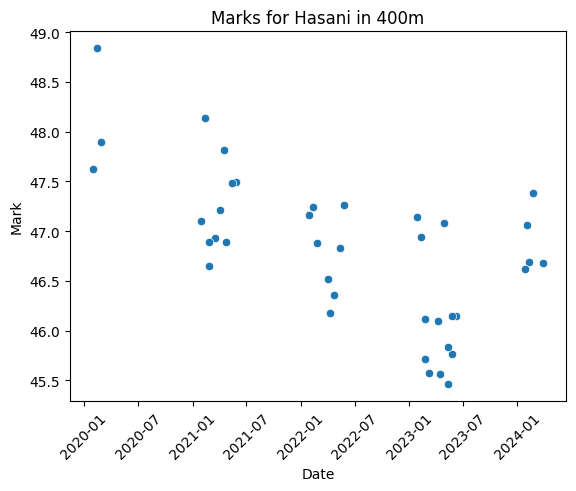

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Scatter Plot
sns.scatterplot(data=df_hasani_400m, x='Date', y='Mark')
plt.xlabel('Date')
plt.ylabel('Mark')
plt.xticks(rotation=45) 
plt.title('Marks for Hasani in 400m')
plt.show()

In [58]:
#400m dataset
df_hasani_400m.head(10)

#partition the data for 400m athletes
X   = df_hasani_400m[['Date']] #input features
y   = df_hasani_400m['Mark']              #target variable

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.3,  #set aside 30% of the data as the test set
                                                    random_state=42, #reproduce the results
                                                    #stratify=y      #preserve the distribution of the labels
                                                   )

In [59]:

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Maximum number of features to consider at each split
}


# Initialize DecisionTreeRegressor
regressor = DecisionTreeRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Get the best estimator
best_regressor = grid_search.best_estimator_

# Predict on the test set using the best estimator
y_pred = best_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean Squared Error: 0.23014479166666688


## Model Analysis 
Fitting 5 folds for each of 72 candidates, totalling 360 fits
- Best Parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
- Mean Squared Error: 0.23014479166666688
